<center>

*******************************************************************************************
<font size="4">
Son &nbsp; &nbsp; <br>
Synchronisation of Swaying Motion<br>
<font size="3">
Exploration<br>
</font>

##### 22 September 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* This program is to explore data aimed to measure the synchronisation of musicians intermittently swaying to the beat of the music. The raw data is a performance of musicians standing up, recorded in video. The musicians swayed intermittently,  depending on how busy they were playing or singing. In this context, the sway consists of giving a small step to one side, waiting four beats, then giving a step to the other side, waiting four beats, and so on. The number of musicians swaying was annotated in sections. A section starts when the number of swaying musicians changes. Also, the average sway frequency was obtained by manually tapping, and found to be 0.28 Hz. The correspondence of measured synhcronisation and number of annotated musicians swaying, is assessed by rank correlation.
>
* This program demonstrates the following measures to quantify synchronisation:
    *  Kuramoto order parameter *r* (Strogatz, 2000): Phase coherence (how close in phase the oscillators are).
    *  Cluster Phase *Rho* (Richardson et al., 2012): A statistical version of Kuramoto's *r*.
    *  Phase-Locking Values (*PLV*) (Mormann et al., 2000): Stability of phase difference, in time.
    *  Wavelet Coherence Transform (*WCT*) (Torrence & Compo 1998): Consistency of phase difference, in time.
    *  Generalized Cross-Wavelet Transform (*GXWT*) (Toiviainen & Hartmann, 2022): Amplitude and absolute-valued time-consistency of phase difference (when the phase difference is pi radians, it's considered in phase).\
\
Note: *WCT* and *GXWT* are based on the Continuous Wavelet Transform (*CWT*)
>
* Data:
    * Video: https://osf.io/gnybc
        * Reference:\
            Clayton, M., Tarsitani, S., Jankowsky, R., Jure, L., Leante, L., Polak, R., ... & Jakubowski, K. (2021). The interpersonal entrainment in music performance data collection. *Empirical Musicology Review, 16*(1), 65-84.
    * Tracked pose raw and preprocessed: https://osf.io/3nfs9
>
* Instructions:

    Edit the values indicated with an arrow like this: <---\
    Matlab is required to run the GXWT. The rest will work fine without Matlab. More information about calling Matlab from Python in the file [GXWT.ipynb](../GXWT.ipynb ).

*******************************************************************************************

In [1]:
import sys

import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

sc_path = '../../src'
sys.path.append(sc_path)
import syncoord as sc

matlab_connected = False

***
### Declare paths and parameters

In [2]:
extfunc_path = 'C:/MyTemp/Matlab'     # <--- folder with external Matlab functions or None
gxwt_path = sc_path                   # <--- folder with gxwt Matlab function or None

main_data_path = 'C:/Users/me'
project_folder = main_data_path + '/Son'               # <--- project folder

annot_path = project_folder + '/Son_annot_sc.csv'      # <--- annotations (e.g., ID, Start, Sections)

pose_tracking_path = project_folder + '/pose_tracking' # <---
prep_path = pose_tracking_path + '/preprocessed'       # <--- preprocessed data (parquet format)

figs_path = project_folder + '/results/figures'

data_fps = 25 # <--- frame rate of video
n_dim = 2     # <--- number of data dimensions
sway_f = 0.28 # <--- sway frequency

***
### Load and visualise data


#### Position
One point of the body (neck) for each musician.

In [3]:
data_1 = sc.ptdata.load( prep_path, {'fps':data_fps,'ndim':n_dim},
                         annot_path=annot_path, print_info=True )

index; key; Name; duration (s):
  0; 0; Son; 5:58.600


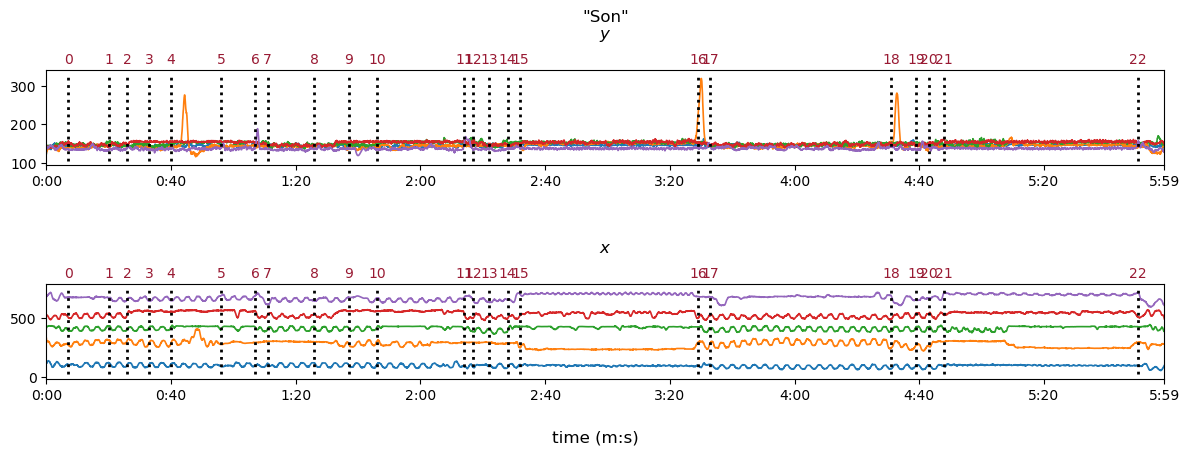

In [4]:
data_1.visualise()

>
#### Number of swaying points
Manually annotated for each section.

In [5]:
n_frames = data_1.data[0].shape[-1]
endtime_str = sc.utils.frames_to_minsec_str(n_frames, data_fps)
sec_times_str = data_1.topinfo['Sections'][0] + ',' + endtime_str
sec_times_str = sec_times_str.replace(' ','')
sec_times_f = [0] + sc.utils.minsec_str_to_frames(sec_times_str, data_fps)
print('\nt =',sec_times_str)
nchar_annot_t = [len(s.strip()) for s in sec_times_str.split(',')]
n_swaying = data_1.topinfo['n_swaying'][0].split(',')
n_swaying_str = ','.join([ ' ' * (nsp-1)+nsw for nsw,nsp in zip(n_swaying, nchar_annot_t)])
print('n =',n_swaying_str)
idx_sec_list = [str(i) for i in range(0,len(n_swaying))]
nsp_idx = [(a)-b for a,b in zip(nchar_annot_t, [len(n) for n in idx_sec_list])]
idx_sec_str = ','.join([ ' ' * nsp + isec for isec,nsp in zip(idx_sec_list, nsp_idx)])
print('i =',idx_sec_str)
print('\nt = time (m:s), n = number of swaying musicians, i = index')


t = 7,20,26,33,40,56,1:07,1:11,1:26,1:37,1:46,2:14,2:17,2:22,2:28,2:32,3:29,3:33,4:31,4:39,4:43,4:48,5:50,5:59
n = 0, 4, 5, 3, 4, 2,   1,   0,   4,   3,   4,   2,   0,   2,   3,   2,   2,   0,   4,   3,   4,   3,   1,   0
i = 0, 1, 2, 3, 4, 5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23

t = time (m:s), n = number of swaying musicians, i = index


>
Inspection of sections:

visualise - warning: sections are disabled for frame selection.


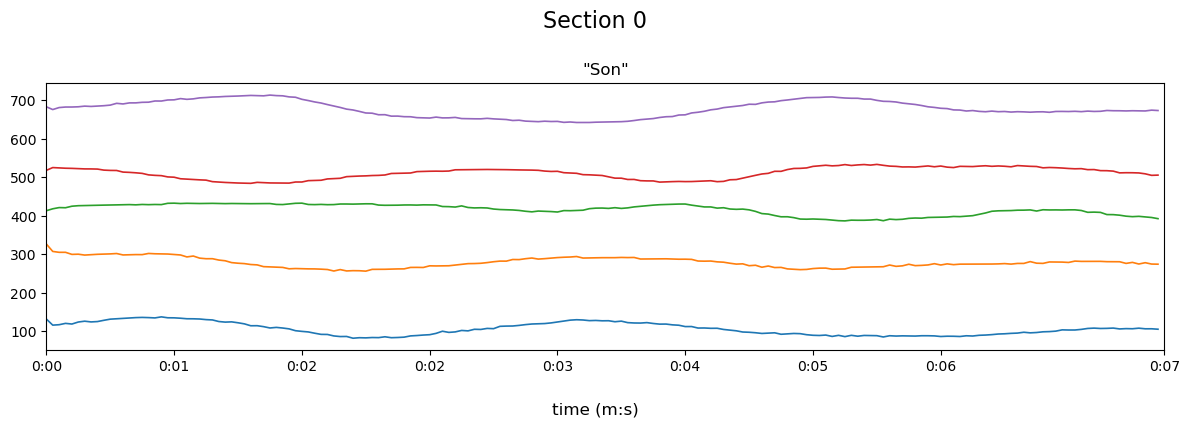

In [6]:
secsel = 0 # <--- section's index

sec_times_f = [0] + sc.utils.minsec_str_to_frames(sec_times_str, data_fps)
data_1.visualise( frame=slice(sec_times_f[secsel], sec_times_f[secsel + 1]),
                  axis=1, vscale=1.5, figtitle=f'Section {secsel}' )

The plots above show that there may be some discrepancy with the annotations. For example, in sections with 0 annotated swaying musicians, there is still oscillatory motion, but not the one of interest (a small step to one side, waiting four beats, then giving a step to the other side, waiting four beats, and so on).
>

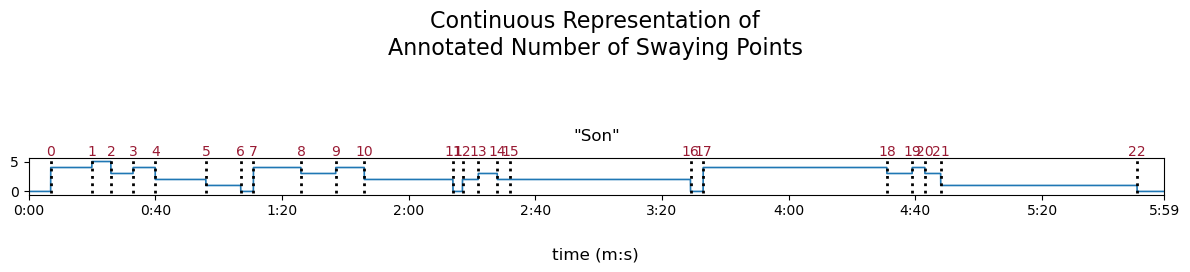

In [7]:
n_frames = data_1.data[0].shape[-1]
sec_f = data_1.topinfo.trimmed_sections_frames[0]+[n_frames]
n_sway = [int(v) for v in data_1.topinfo.n_swaying[0].split(',')]
n_sway_cont = np.zeros(n_frames)
i_prev = 0
for i_next,ns in zip(sec_f,n_sway):
    n_sway_cont[i_prev:i_next] = ns
    i_prev = i_next
nsc_ptd = data_1.copy()
nsc_ptd.data[0] = n_sway_cont
nsc_ptd.visualise(figtitle='Continuous Representation of\nAnnotated Number of Swaying Points')

***
### Low-pass filter 1
Apply to position data.

In [8]:
filter_type = 'savgol'
filter_window_size = None          # <--- (s) or None
# filter_window_size = 1/(4*sway_f)  # <--- (s) or None
filter_polyorder = 1               # <---

if filter_window_size:
    data_2 = sc.ptdata.smooth( data_1, filt_type=filter_type, window_size=filter_window_size,
                               order=filter_polyorder )
    data_2.visualise()
else:
    data_2 = data_1
    print('Filter not applied to position data.')

Filter not applied to position data.


***
### Reduction to one dimension per point

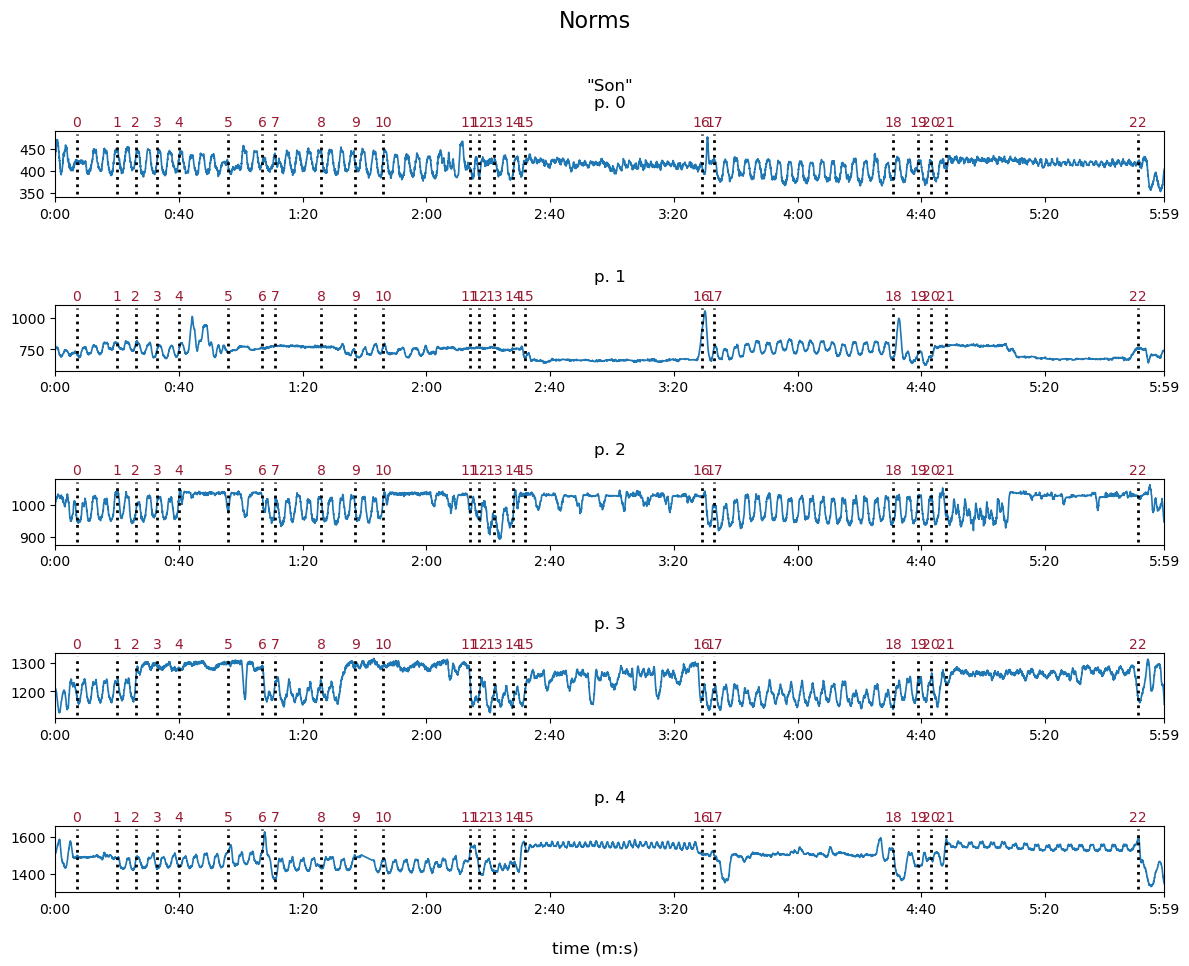

In [9]:
red1D_method = 'norms' # <--- 'norms', 'speed', spatial axis ('x','y'), or None (e.g., for GXWT)

if red1D_method == 'speed':
    data_3 = sc.ptdata.apply( data_2, sc.ndarr.tder, dim=2 )
    fig_title_3 = 'Speed'
elif red1D_method == 'norms':
    n1 = sc.ptdata.norm( data_2, order=1, axis=-2 )
    n2 = sc.ptdata.norm( data_2, order=2, axis=-2 )
    data_3 = sc.ptdata.apply2( n1, n2, np.add )
    fig_title_3 = 'Norms'
elif (red1D_method is not None) and (red1D_method in 'xy'):
    data_3 = sc.ptdata.select( data_2, axis='yx'.index(red1D_method) )
    fig_title_3 = red1D_method
else:
    data_3 = data_2
    print('Reduction to one dimension not performed.')
if red1D_method: data_3.visualise( groupby=None, vscale=0.8, figtitle=fig_title_3 )

***
### Low-pass filter 2
Apply to 1-dimensional data.

In [10]:
filter_type = 'savgol'
filter_window_size = None          # <--- (s) or None
# filter_window_size = 1/(4*sway_f)  # <--- (s) or None
filter_polyorder = 1               # <---

if filter_window_size:
    data_4 = sc.ptdata.smooth( data_3, filter_type=filter_type, window_size=filter_window_size,
                               order=filter_polyorder )
    data_4.visualise( groupby=None, vscale=0.8 )
else:
    data_4 = data_3
    print('Filter not applied to 1-D data.')

Filter not applied to 1-D data.


***
### Phase

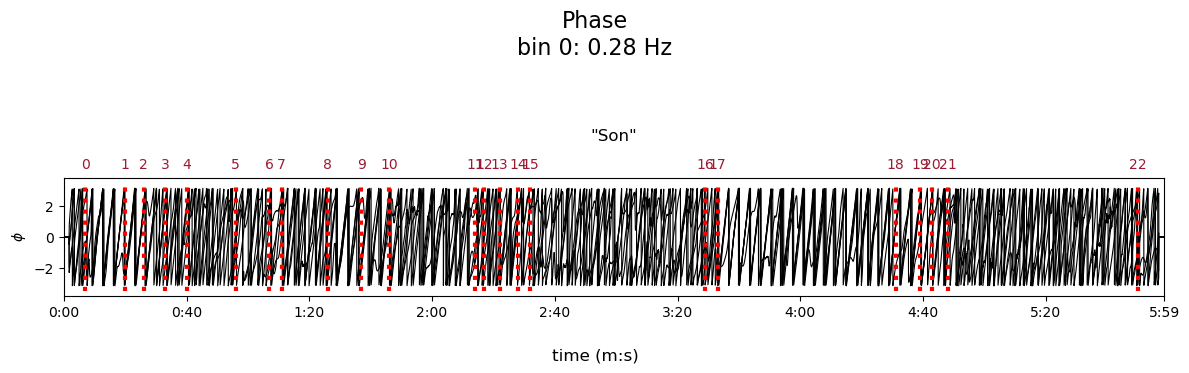

In [11]:
phase_method = 'FFT' # <--- method for phase angles 'peaks', 'FFT' or None (e.g., for WCT and GXWT)
# phase_method = None  # <--- method for phase angles 'peaks', 'FFT' or None (e.g., for WCT and GXWT)

if phase_method == 'peaks':

    min_dist = sway_f/2 # <--- minimum distance between peaks (seconds)

    data_5 = sc.ptdata.peaks_to_phase( data_4, fps=data_fps, min_dist=min_dist,
                                      endstart=True, height=0.2, prominence=0.1 )
    data_5.visualise( groupby=-1, vscale=0.7 )
elif phase_method == 'FFT':

    fft_win_s = 1/sway_f       # <--- FFT window length (seconds)
    sel_freq_bin = 0           # <--- select FFT frequency bins (int, slice, or 'all')

    # fft_win_s = 3/sway_f       # <--- FFT window length (seconds)
    # sel_freq_bin = slice(0,21) # <--- select FFT frequency bins (int, slice, or 'all')

    data_5 = sc.ptdata.fourier( data_4, fft_win_s, output='phase', mode='same' )
    if sel_freq_bin == 'all':
        data_5.visualise( vscale=0.7 )
    else:
        data_5 = sc.ptdata.select( data_5, frequency=sel_freq_bin )
        if isinstance(sel_freq_bin,slice): vscale_ph = 1-(data_5.data[0].shape[-2]-1)*0.015
        else: vscale_ph = 1.3
        data_5.visualise( vscale=vscale_ph )
    if data_5.data[0].shape[-2] == 1: print(data_5.labels.dimel[-2][0])
else:
    data_5 = data_4
    print('Phase not computed.')

***
### Synchronisation

C:\Users/juigmend/local_documents/SynCoord/src\syncoord\ptdata.py:1199: RuntimeWarning: Mean of empty slice
  dd_out[k] = np.nanmean(dd_in[k],axis=axis)


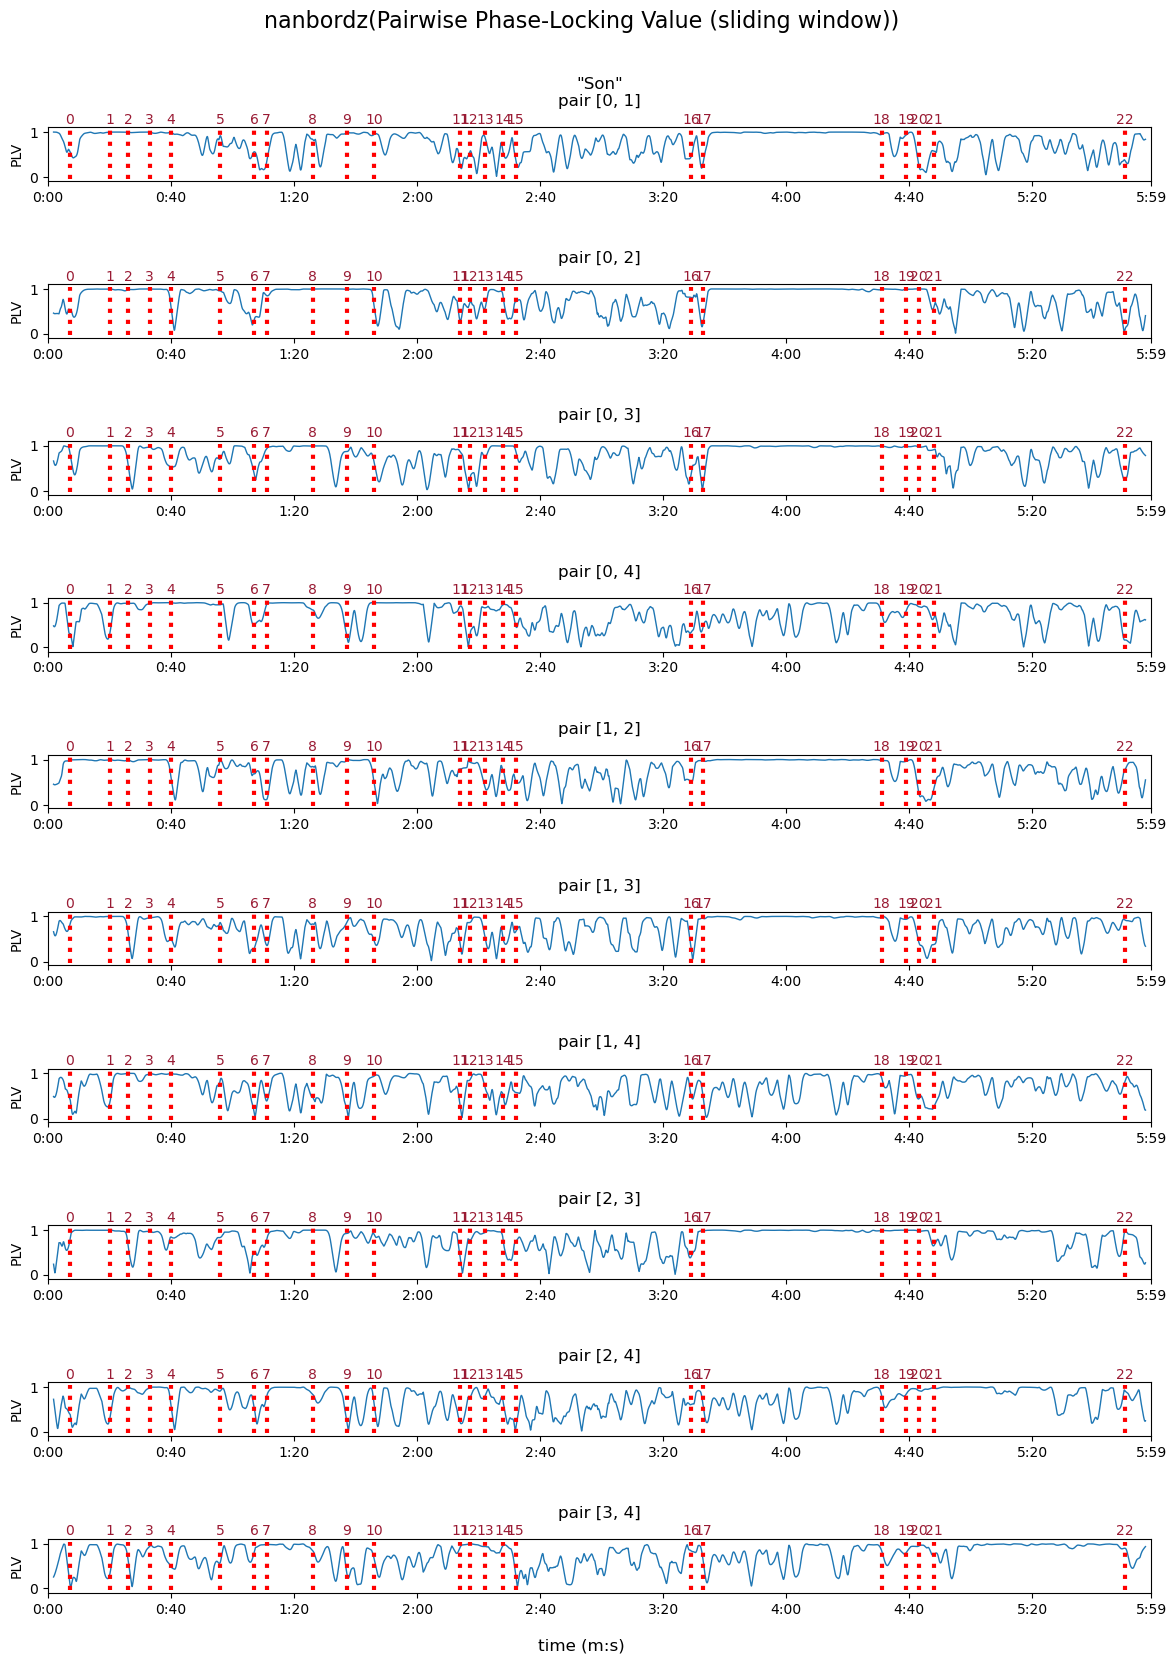

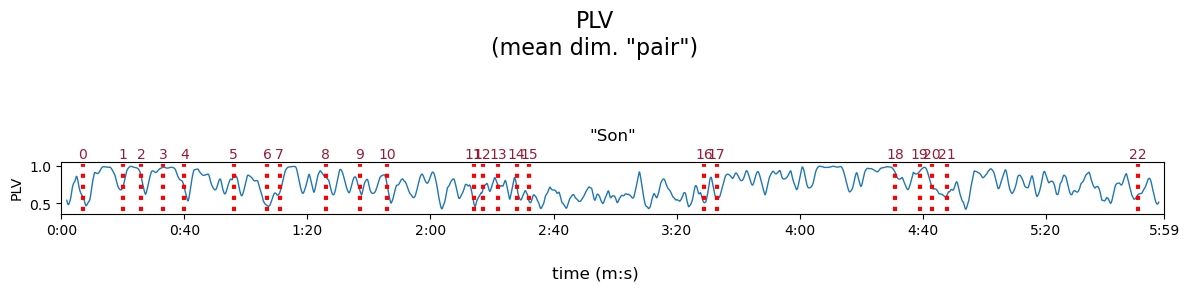

In [12]:
sync_method = 'PLV'  # <--- 'r', 'Rho', 'PLV', WCT', or 'GXWT'

sync_vscale = 1
if sync_method == 'r':
    sync_1 = sc.ptdata.kuramoto_r( data_5 )

elif sync_method == 'Rho':
    sync_1 = sc.ptdata.rho( data_5 )

elif sync_method == 'PLV':

    plv_window = 1/sway_f           # <--- PLV window (seconds)
    # plv_window = 3/sway_f           # <--- PLV window (seconds)

    plv_pairwise = sc.ptdata.plv( data_5, plv_window )
    plv_margin = round(plv_window*data_fps)
    plv_pairwise = sc.ptdata.apply( plv_pairwise, sc.utils.nanbordz, margin=plv_margin )
    plv_pairwise.labels.main = 'PLV'
    plv_pairwise.visualise( dlattr='1', vscale=0.7 )
    sync_1 = sc.ptdata.aggrax( plv_pairwise, function='mean' )
    sync_1.names.main = 'PLV\n(mean dim. "pair")'

elif sync_method == 'WCT':

    minmaxf = [sway_f, sway_f]      # <--- frequencies (Hz) [minimum, maximum], can be the same
    # minmaxf = [0.1, 2]              # <--- frequencies (Hz) [minimum, maximum], can be the same

    wct_pairwise = sc.ptdata.wct( data_5, minmaxf, 0, -1, postprocess='coinan' )
    if len(set(minmaxf)) > 1:
        wct_vscale = 1
        sync_vscale = 1.3
    else: wct_vscale = 0.7
    wct_pairwise.visualise(vscale=wct_vscale)
    sync_1 = sc.ptdata.aggrax( wct_pairwise, axis=0, function='mean' )

elif sync_method == 'GXWT':

    b = 0.005
    minmaxf = [sway_f-b, sway_f+b]  # <--- frequencies (Hz) [minimum, maximum], cannot be the same
    # minmaxf = [0.1, 2]              # <--- frequencies (Hz) [minimum, maximum], cannot be the same

    if matlab_connected: print('Already connected to Matlab.')
    else: # allow to run sc.ptdata.gxwt multiple times without reconnecting to Matlab
        matlabeng = sc.utils.matlab_eng([extfunc_path,gxwt_path])
        matlab_connected = True
    if len(data_5.names.dim) == 3: fixed_axes = [-2,-1]
    elif len(data_5.names.dim) == 2: fixed_axes = -1
    gxwt_pairwise = sc.ptdata.gxwt( data_5, minmaxf, 0, fixed_axes, matlabeng=matlabeng  )
    if 'frequency' in gxwt_pairwise.names.dim:
        gxwt_vscale = 1
        sync_vscale = 1.3
    else: gxwt_vscale = 0.6
    gxwt_pairwise.visualise(vscale=gxwt_vscale)
    sync_1 = sc.ptdata.aggrax( gxwt_pairwise, axis=0, function='mean' )

else: raise Exception('invalid value for sync_method')

sync_1.visualise( vscale=sync_vscale )

In [13]:
try:
    if sync_1.names.dim[-2] == 'frequency':
        sync_2 = sc.ptdata.aggrax( sync_1, axis=-2, function='mean' )
        sync_2.visualise( x_ticklabelling='s' )
    else: sync_2 = sync_1
except: sync_2 = sync_1

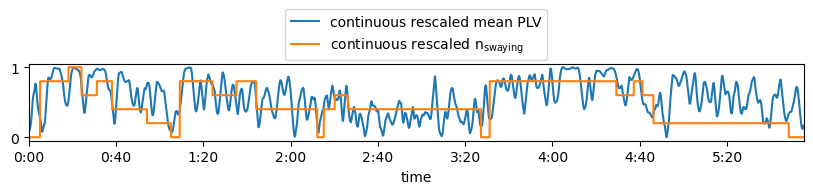

In [14]:
d_margin = next(i for i,v in enumerate(sync_2.data[0]) if not np.isnan(v) )
sync_2_data_valid = sync_2.data[0][slice(d_margin,len(sync_2.data[0])-d_margin-1)]
nsc_ptd_data_valid = nsc_ptd.data[0][slice(d_margin,len(nsc_ptd.data[0])-d_margin-1)]
sync_2_data_valid_rs = sync_2_data_valid - min(sync_2_data_valid)
sync_2_data_valid_rs = sync_2_data_valid_rs / max(sync_2_data_valid_rs)
nsc_ptd_data_valid_rs = nsc_ptd_data_valid - min(nsc_ptd_data_valid)
nsc_ptd_data_valid_rs = nsc_ptd_data_valid_rs / max(nsc_ptd_data_valid_rs)
plt.figure(figsize=(10,1))
plt.plot(sync_2_data_valid_rs, label=f'continuous rescaled mean {sync_method}')
plt.plot(nsc_ptd_data_valid_rs, label=r'continuous rescaled $\mathregular{n_{swaying}}$')
plt.xlim(0,len(nsc_ptd_data_valid_rs))
xticks_f = plt.xticks()[0]
if xticks_f[-1] > len(nsc_ptd_data_valid_rs): xticks_f = np.delete(xticks_f,-1)
xtkcks_lbl = [sc.utils.frames_to_minsec_str(f,data_fps) for f in xticks_f]
plt.xticks(xticks_f,xtkcks_lbl)
plt.xlabel('time')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.8));

>
#### Rank correlation between continuous synchronisation and annotation

In [15]:
if len(sync_2_data_valid) < len(nsc_ptd_data_valid): nsc_ptd_data_valid = nsc_ptd_data_valid[:-1]
tau_c,p_c = stats.kendalltau(sync_2_data_valid, nsc_ptd_data_valid)
print('Tau =',round(tau_c,3))
def pvdisp(pval, sigdec=3):
    thresh = 10**-sigdec
    if pval < thresh: return f'p value < {thresh}'
    else: return f'p value = {round(pval,sigdec)}'
print(pvdisp(p_c))

Tau = 0.33
p value < 0.001


***
### Sections' means

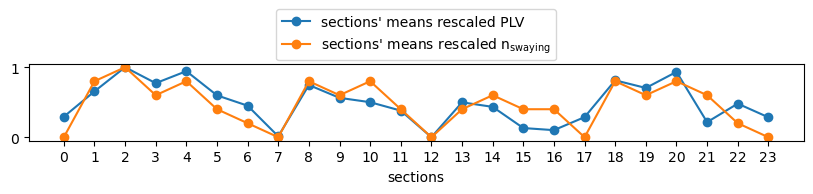

In [16]:
sync_secmeans = sc.ptdata.secstats( sync_2, statnames='mean', last=True, omitnan=True )
sync_secmeans_rs = sync_secmeans.data[0] - min(sync_secmeans.data[0])
sync_secmeans_rs = sync_secmeans_rs / max(sync_secmeans_rs)
n_sway_rs = [v/max(n_sway) for v in n_sway]
n_sec = len(sync_secmeans_rs)
plt.figure(figsize=(10,1))
plt.plot(sync_secmeans_rs,marker='o', label=f"sections' means rescaled {sync_method}")
plt.plot(n_sway_rs,marker='o', label=r"sections' means rescaled $\mathregular{n_{swaying}}$")
new_xticks = range(0,n_sec)
plt.xticks(range(len(new_xticks)),new_xticks)
plt.xlabel('sections')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.8));

>
#### Rank correlation between section's means and annotations

In [17]:
tau_m,p_m = stats.kendalltau(sync_secmeans_rs, n_sway_rs)
print('Tau =',round(tau_m,3))
print(pvdisp(p_m))

Tau = 0.659
p value < 0.001
